Importar las librerías necesarias

In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Add, Flatten, Dense, AveragePooling2D, Dropout
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import Sequential

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools 

Montar el dataset alojado en Google Drive y descomprimirlo para usar la data

In [2]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#!ls "/content/drive/MyDrive/VISIÓN ARTIFICIAL/SIMPLE"
!ls "/datasets/face-mask-data2"
#!unzip /datasets/face-mask-data2/SIMPLE-20220701T152021Z-001.zip
!ls /notebooks/SIMPLE


SIMPLE-20220701T152021Z-001.zip
incorrect_mask	with_mask  without_mask


Definiión de algunos parámetros generales para entrenamiento

In [3]:
target_size = (224, 224)
batch_size = 32
epochs = 25

Leer el dataaset separándo la data de entrenamiento y validación

In [4]:
train_dir = '/notebooks/SIMPLE'
datagenerator = ImageDataGenerator(
    #rescale=1.0 / 255, 
    #horizontal_flip=True, 
    zoom_range=0.01, 
    shear_range=0.25, 
    validation_split=0.30
)

train_dataset = datagenerator.flow_from_directory(
    directory=train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_dataset = datagenerator.flow_from_directory(
    directory=train_dir, # same directory as training data
    target_size=target_size,
    batch_size=1,
    class_mode='categorical',
    subset='validation') # set as validation data

mask_labels = {v: k for k, v in train_dataset.class_indices.items()}
mask_labels

Found 1259 images belonging to 3 classes.
Found 539 images belonging to 3 classes.


{0: 'incorrect_mask', 1: 'with_mask', 2: 'without_mask'}

Crear el modelo usando transfer learning de Xception

In [5]:
class FixedMean(tf.keras.metrics.Mean):
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_pred, sample_weight=sample_weight)
        
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=train_dataset.image_shape,
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=train_dataset.image_shape)
x = data_augmentation(inputs)  # Apply random data augmentation

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

x = base_model(x, training=False)

x = AveragePooling2D(pool_size=(5, 5))(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)# Regularize with dropout
#x = Dense(128, activation="relu")(x)

outputs = keras.layers.Dense(3, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=[keras.metrics.Precision(), keras.metrics.Recall()]
)



2022-07-11 00:07:55.314906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 00:07:55.372971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 00:07:55.373566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 00:07:55.376193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 00:07:55.376780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 2048)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 2048)              0      

Relizar el entrenamiento

In [7]:
model_history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset
)

Epoch 1/25
40/40 [==============================] - 28s 706ms/step - loss: 0.3710 - precision: 0.6667 - recall: 0.9277 - val_loss: 0.4229 - val_precision: 0.6005 - val_recall: 0.9147
Epoch 2/25
40/40 [==============================] - 28s 707ms/step - loss: 0.3187 - precision: 0.6588 - recall: 0.9508 - val_loss: 0.3865 - val_precision: 0.6091 - val_recall: 0.9425
Epoch 3/25
40/40 [==============================] - 27s 679ms/step - loss: 0.2924 - precision: 0.6609 - recall: 0.9754 - val_loss: 0.3071 - val_precision: 0.6032 - val_recall: 0.9759
Epoch 4/25
40/40 [==============================] - 27s 682ms/step - loss: 0.2647 - precision: 0.6501 - recall: 0.9754 - val_loss: 0.2700 - val_precision: 0.6025 - val_recall: 0.9814
Epoch 5/25
40/40 [==============================] - 27s 682ms/step - loss: 0.2531 - precision: 0.6771 - recall: 0.9762 - val_loss: 0.3050 - val_precision: 0.6225 - val_recall: 0.9666
Epoch 6/25
40/40 [==============================] - 27s 672ms/step - loss: 0.2384 - p

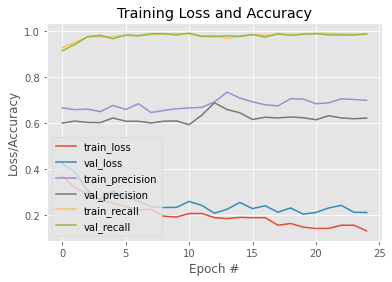

In [8]:
N = epochs
H = model_history
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["precision"], label="train_precision")
plt.plot(np.arange(0, N), H.history["val_precision"], label="val_precision")
plt.plot(np.arange(0, N), H.history["recall"], label="train_recall")
plt.plot(np.arange(0, N), H.history["val_recall"], label="val_recall")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [9]:
model.save('face_mask_cat_Xception.h5')

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Inferencia

Preparamos la data para pruebas

In [10]:
new_model = tf.keras.models.load_model('face_mask_cat_Xception.h5')
#new_model.summary()

In [11]:
evaluation = new_model.evaluate(validation_dataset)

539/539 [==============================] - 14s 23ms/step - loss: 0.2028 - precision: 0.6212 - recall: 0.9889


In [12]:
y_pred = []
errors_index = {}
for i in range(len(validation_dataset.filenames)):
    img_path = '/notebooks/SIMPLE/' + validation_dataset.filenames[i]
    image_loaded = load_img(img_path, target_size=target_size)
    image = img_to_array(image_loaded)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    preds = new_model.predict(image)[0]
    y_pred.append(preds.argmax(axis=-1))
    if preds.argmax(axis=-1) != validation_dataset.classes[i]:
        #print(i, mask_labels[preds.argmax(axis=-1)] , mask_labels[validation_dataset.classes[i]])
        errors_index[i] = image_loaded

In [13]:
cm = confusion_matrix(validation_dataset.classes, y_pred)
cm

array([[164,  14,   1],
       [ 20, 156,   4],
       [  3,   1, 176]])

Normalized confusion matrix


/tmp/ipykernel_108/5753814.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Text(0.5, 66.2363896451549, 'Predicted label')

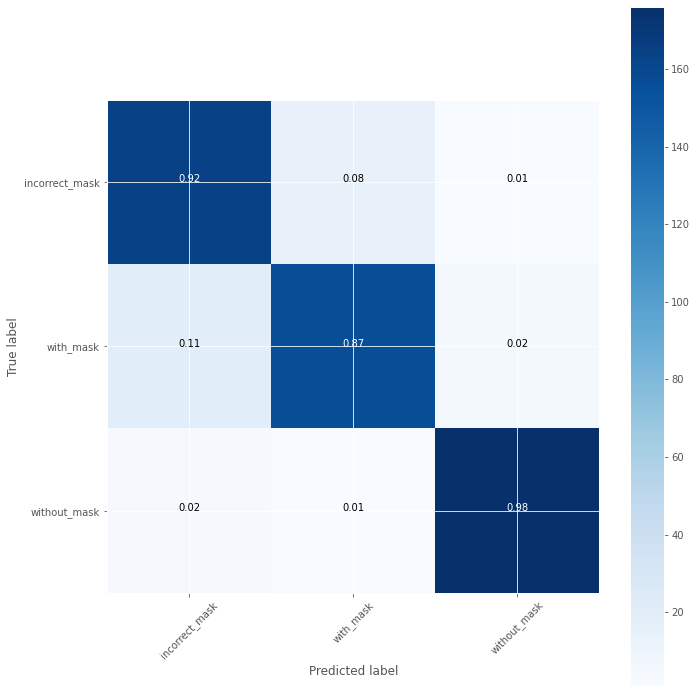

In [17]:
normalize = True
target_names = []
for key in validation_dataset.class_indices:
    target_names.append(key)
    

cm = confusion_matrix(validation_dataset.classes, y_pred)

plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#plt.title(title)
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')

thresh = cm.max() / 2.

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

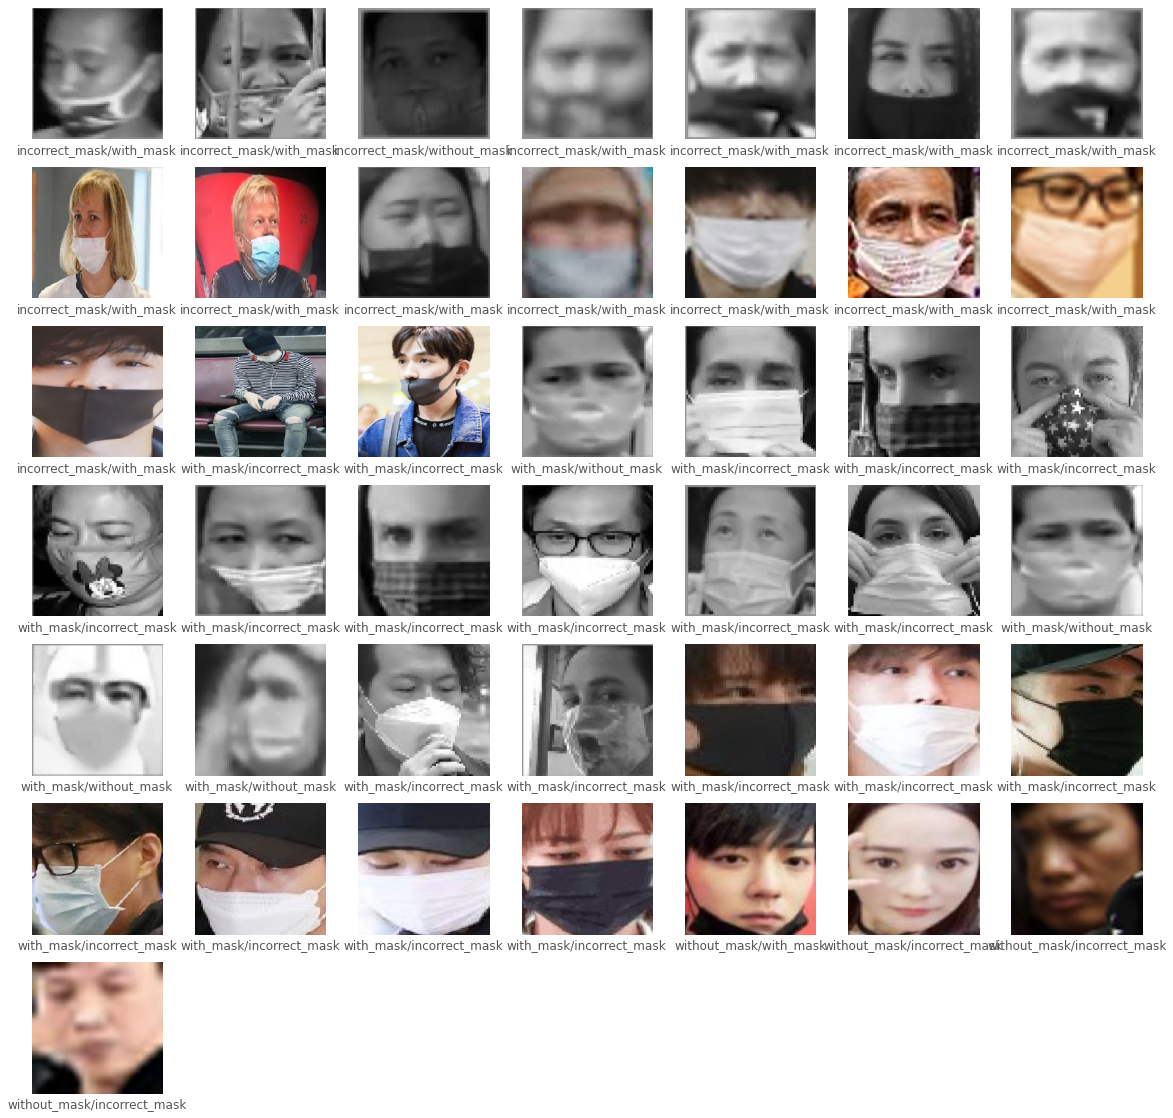

In [15]:
plt.figure(figsize=(20,20))
order = 0
for i,img in errors_index.items():
    if order>=49: break
    plt.subplot(7,7,order+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(mask_labels[validation_dataset.classes[i]]+'/'+mask_labels[y_pred[i]])
    order += 1
plt.show()